In [6]:
# imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16

In [51]:
data_path = 'dog/Dog Emotion/'#'/kaggle/input/dog-emotion/Dog Emotion/'

# Get class names from directory (excluding 'labels.csv')
class_names = sorted(os.listdir(data_path))
class_names.remove('labels.csv')
class_names.remove('.ipynb_checkpoints')
num_classes = len(class_names)

img_size = (192, 192, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')

images = []
labels = []
labels_df = pd.read_csv(data_path + 'labels.csv')

print('\n\nlabels dataframe: \n', labels_df.head())

# Iterate over rows using iterrows() to avoid FutureWarning
for index, row in labels_df.iterrows():
    image_path = data_path + row['label'] + '/' + row['filename']
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (img_size[0], img_size[1]))[:, :, ::-1]  # Resize and convert BGR to RGB
    images.append(np.asarray(image))
    
    # Create label vector in the form [0, 1, 0, 0] or [1, 0, 0, 0]
    label = np.zeros(num_classes)
    label[class_names.index(row['label'])] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (192, 192, 3)


labels dataframe: 
    Unnamed: 0                               filename    label
0           0  yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg      sad
1           1  c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg      sad
2           2  RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg    angry
3           3  gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg    angry
4           4  U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg  relaxed

labels shape: (4000, 4)
images shape: (4000, 192, 192, 3)


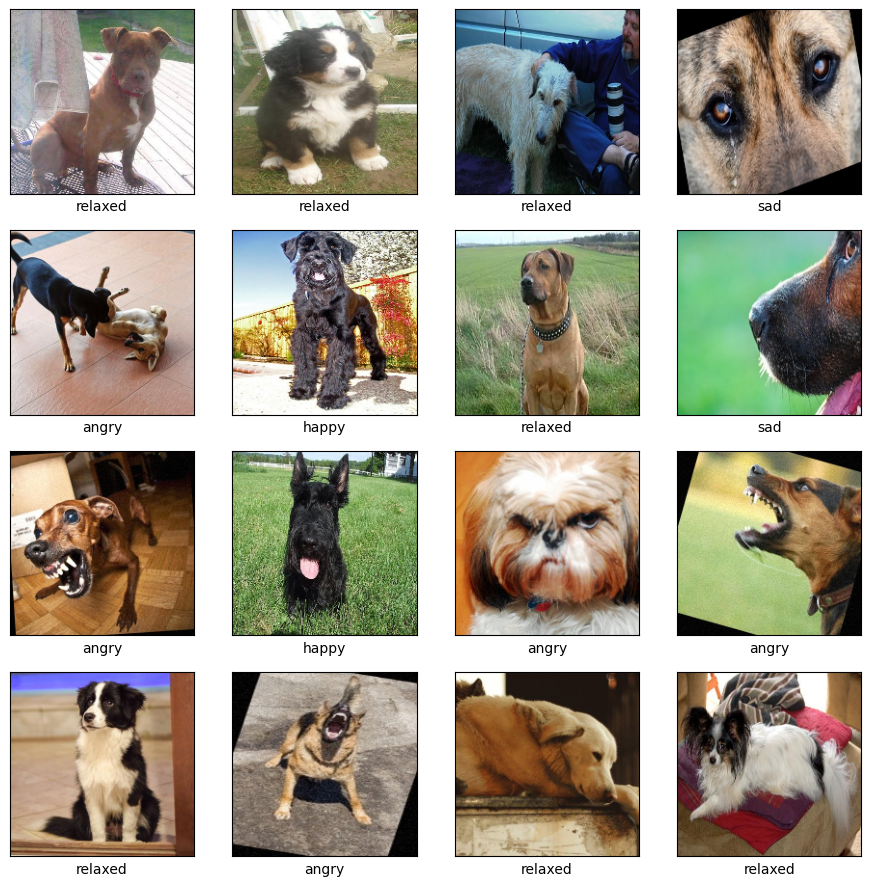

In [9]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
plt.show()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

# Initialize ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow from arrays: Create the generator from numpy arrays
batch_size = 32  # Adjust batch size as per your requirements
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data
)

# Print information about the generator
print(f"Number of batches per epoch: {len(train_generator)}")
print(f"Number of samples: {train_generator.n}")


train images shape: (2800, 192, 192, 3)
train labels shape: (2800, 4)

validation images shape: (1200, 192, 192, 3)
validation labels shape: (1200, 4)

Number of batches per epoch: 88
Number of samples: 2800


In [14]:
# transfer learning model with freezing every layer

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
# Freeze the layers of the base model
i = 0
for layer in base_model.layers:
    layer.trainable = False
    if i == 4:
        break

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Callbacks
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras')

history = model.fit(images, labels, epochs=7, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.4094 - loss: 14.9610 - val_accuracy: 0.7383 - val_loss: 0.7882
Epoch 2/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6095 - loss: 1.3586 - val_accuracy: 0.8500 - val_loss: 0.4482
Epoch 3/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7135 - loss: 0.7827 - val_accuracy: 0.9033 - val_loss: 0.2693
Epoch 4/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.7642 - loss: 0.6050 - val_accuracy: 0.9467 - val_loss: 0.1882
Epoch 5/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8072 - loss: 0.4809 - val_accuracy: 0.9467 - val_loss: 0.1465
Epoch 6/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8183 - loss: 0.4378 - val_accuracy: 0.9775 - val_loss: 0.1059
Epoch 7/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.8664 - loss: 0.3376 - val_accuracy: 0.9842 - val_loss: 0.0733


'history = model.fit(\n    train_generator,\n    steps_per_epoch=len(train_generator),\n    validation_data=(X_val, y_val),\n    epochs=10,\n    callbacks=[early_stopping, model_checkpoint]\n)'

In [16]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(X_val, y_val)

# Print evaluation results
print(f'Validation loss: {loss:.4f}')
print(f'Validation accuracy: {accuracy:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9820 - loss: 0.0761
Validation loss: 0.0733
Validation accuracy: 0.9842


In [88]:
# display confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
pred = model.predict(X_val)

C:\Users\munch\miniconda3\envs\neuralNetworks\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step


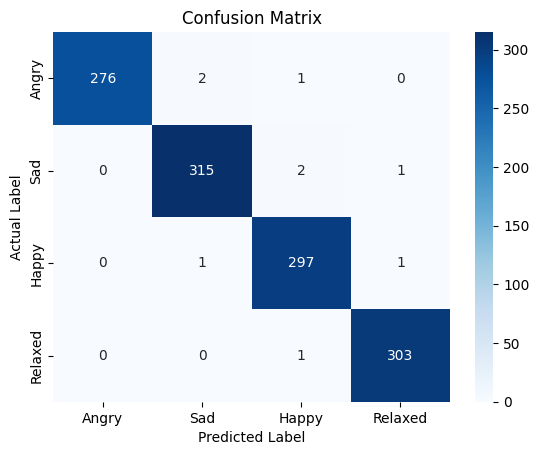

In [108]:
import seaborn as sns
y_test = ["" for x in range(len(y_val))]
y_pred = ["" for x in range(len(pred))]
i = 0
for x in y_val:
    y_test[i] = class_names[np.argmax(x)]
    i=i+1
i = 0
for x in pred:
    y_pred[i] = class_names[np.argmax(x)]
    i=i+1
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix with seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Angry', 'Sad', 'Happy', 'Relaxed'], 
            yticklabels=['Angry', 'Sad', 'Happy', 'Relaxed'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


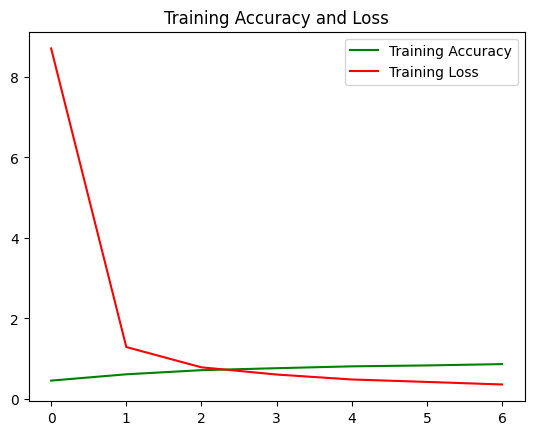

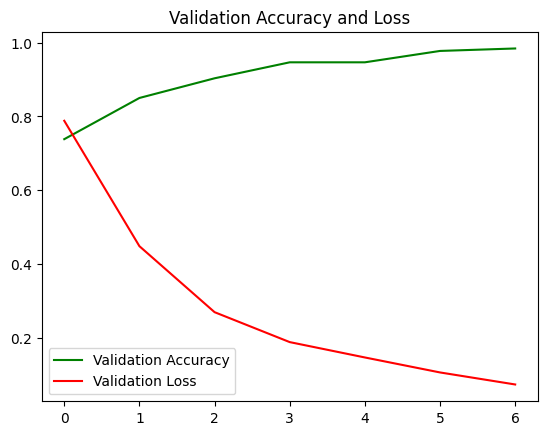

In [101]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs, loss, label='Training Loss', color='red')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

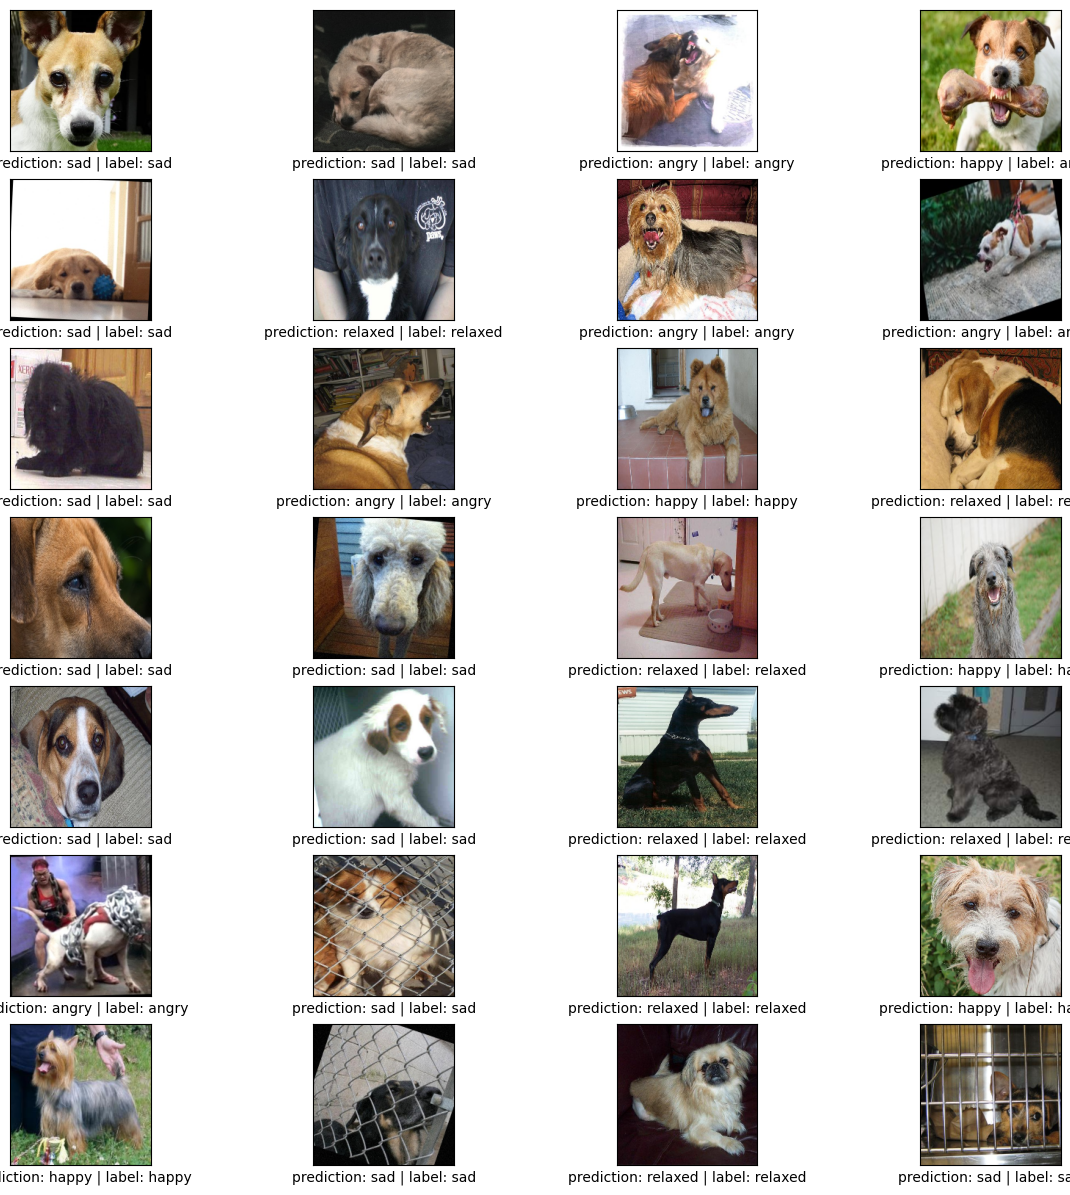

In [25]:
fig, axs = plt.subplots(7, 4, figsize=(15, 15))

i = 0
for x in range(7):
    for y in range(4):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


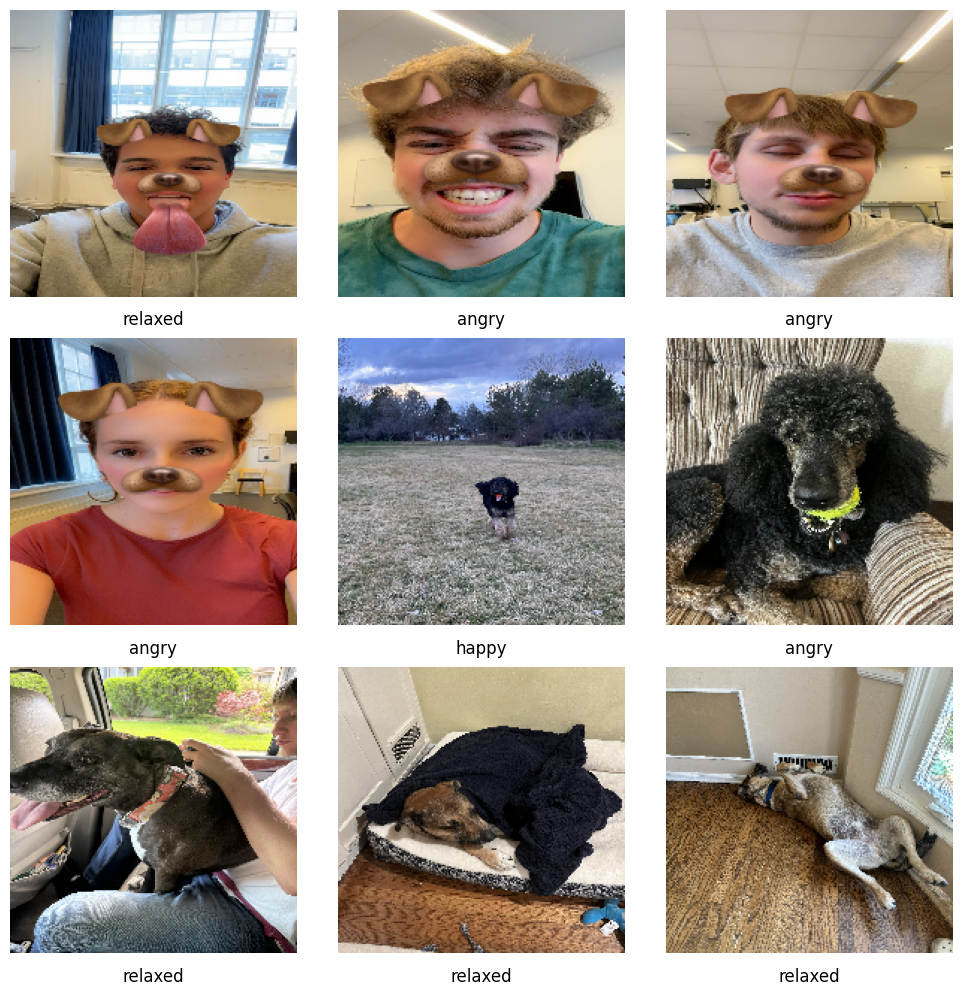

In [58]:
import matplotlib.image as mpimg
image_paths = ['dog1.jpg', 'dog2.jpg', 'dog3.jpg', 'dog4.jpg', 'micahdog.jpg', 'micahdog3.jpg', 'zachdog.jpg', 'travisdog.jpg', 'travisdog2.jpg']
subtext = ["" for x in range(9)]
i = 0
for imag in image_paths:
    img = cv2.imread(imag, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (192, 192))  # Resize to match your model's expected sizing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Preprocess the image
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    predictions = model.predict(img)
    # Get the predicted class label
    predicted_class = np.argmax(predictions)
    subtext[i] = class_names[predicted_class]
    i=i+1;


# Number of rows and columns
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    # Load image
    imag = image_paths[i]
    #img = mpimg.imread(image_paths[i])
    img = cv2.imread(imag, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (192, 192))  # Resize to match your model's expected sizing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Display image
    ax.imshow(img)
    ax.axis('off')  # Hide the axes ticks

    # Display subtext
    #ax.set_title(subtext[i], fontsize=12)
    ax.text(0.5, -0.1, subtext[i], fontsize=12, ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [109]:
# transfer learning model with freezing SOME layers
from tensorflow.keras import layers, optimizers, models

part1 = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze the layers of the base model
i = 0
for layer in part1.layers:
    layer.trainable = False
    if i == 10:
        break

part2 = Sequential([
    #base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

optimizer1 = optimizers.Adam(learning_rate=0.01)
optimizer2 = optimizers.Adam(learning_rate=0.0001)
part1.compile(optimizer=optimizer1, loss="categorical_crossentropy", metrics=['accuracy'])
part2.compile(optimizer=optimizer2, loss="categorical_crossentropy", metrics=['accuracy'])
combined_model = models.Model(inputs=part1.input, outputs=part2(part1.output))


In [110]:
# Callbacks
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras')

history = model.fit(images, labels, epochs=7, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/7


C:\Users\munch\miniconda3\envs\neuralNetworks\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 720s 6s/step - accuracy: 0.9000 - loss: 0.2523 - val_accuracy: 0.9975 - val_loss: 0.0306
Epoch 2/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 713s 6s/step - accuracy: 0.9165 - loss: 0.2155 - val_accuracy: 0.9975 - val_loss: 0.0285
Epoch 3/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 708s 6s/step - accuracy: 0.9154 - loss: 0.2071 - val_accuracy: 0.9983 - val_loss: 0.0219
Epoch 4/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 716s 6s/step - accuracy: 0.9211 - loss: 0.1886 - val_accuracy: 0.9983 - val_loss: 0.0179
Epoch 5/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 714s 6s/step - accuracy: 0.9350 - loss: 0.1755 - val_accuracy: 0.9983 - val_loss: 0.0172
Epoch 6/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 714s 6s/step - accuracy: 0.9327 - loss: 0.1795 - val_accuracy: 0.9992 - val_loss: 0.0163
Epoch 7/7
125/125 ━━━━━━━━━━━━━━━━━━━━ 708s 6s/step - accuracy: 0.9332 - loss: 0.1793 - val_accuracy: 0.9992 - val_loss: 0.0138


In [111]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(X_val, y_val)

# Print evaluation results
print(f'Validation loss: {loss:.4f}')
print(f'Validation accuracy: {accuracy:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9998 - loss: 0.0110
Validation loss: 0.0138
Validation accuracy: 0.9992


In [112]:
# display confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
pred = model.predict(X_val)

38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step


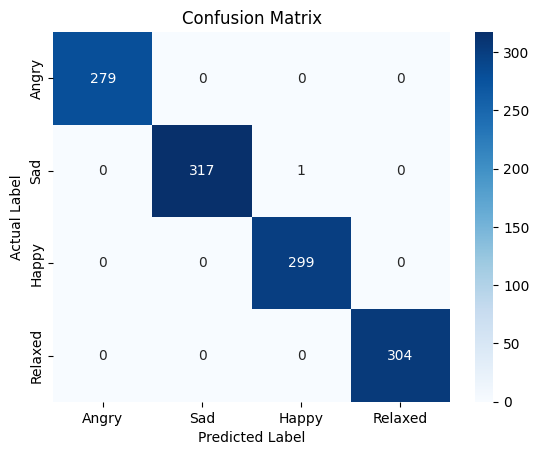

In [113]:
import seaborn as sns
y_test = ["" for x in range(len(y_val))]
y_pred = ["" for x in range(len(pred))]
i = 0
for x in y_val:
    y_test[i] = class_names[np.argmax(x)]
    i=i+1
i = 0
for x in pred:
    y_pred[i] = class_names[np.argmax(x)]
    i=i+1
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix with seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Angry', 'Sad', 'Happy', 'Relaxed'], 
            yticklabels=['Angry', 'Sad', 'Happy', 'Relaxed'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


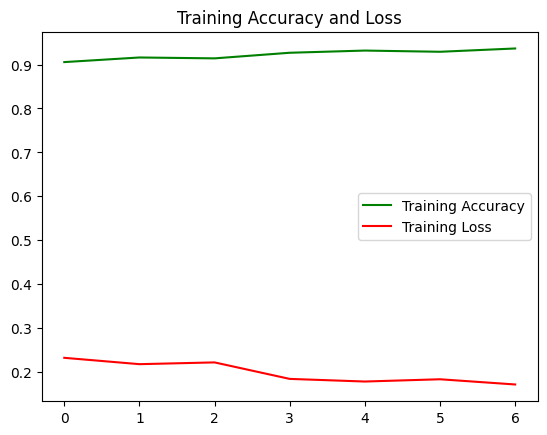

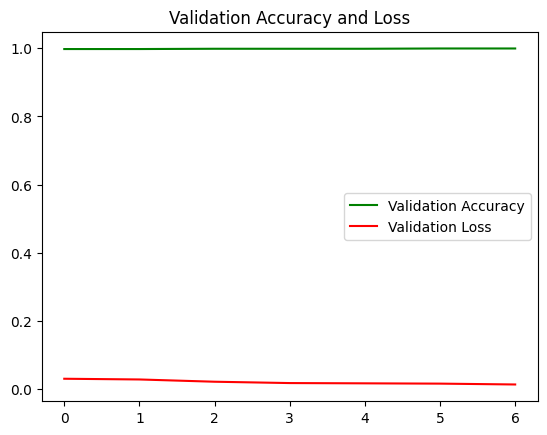

In [114]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs, loss, label='Training Loss', color='red')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

C:\Users\munch\miniconda3\envs\neuralNetworks\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


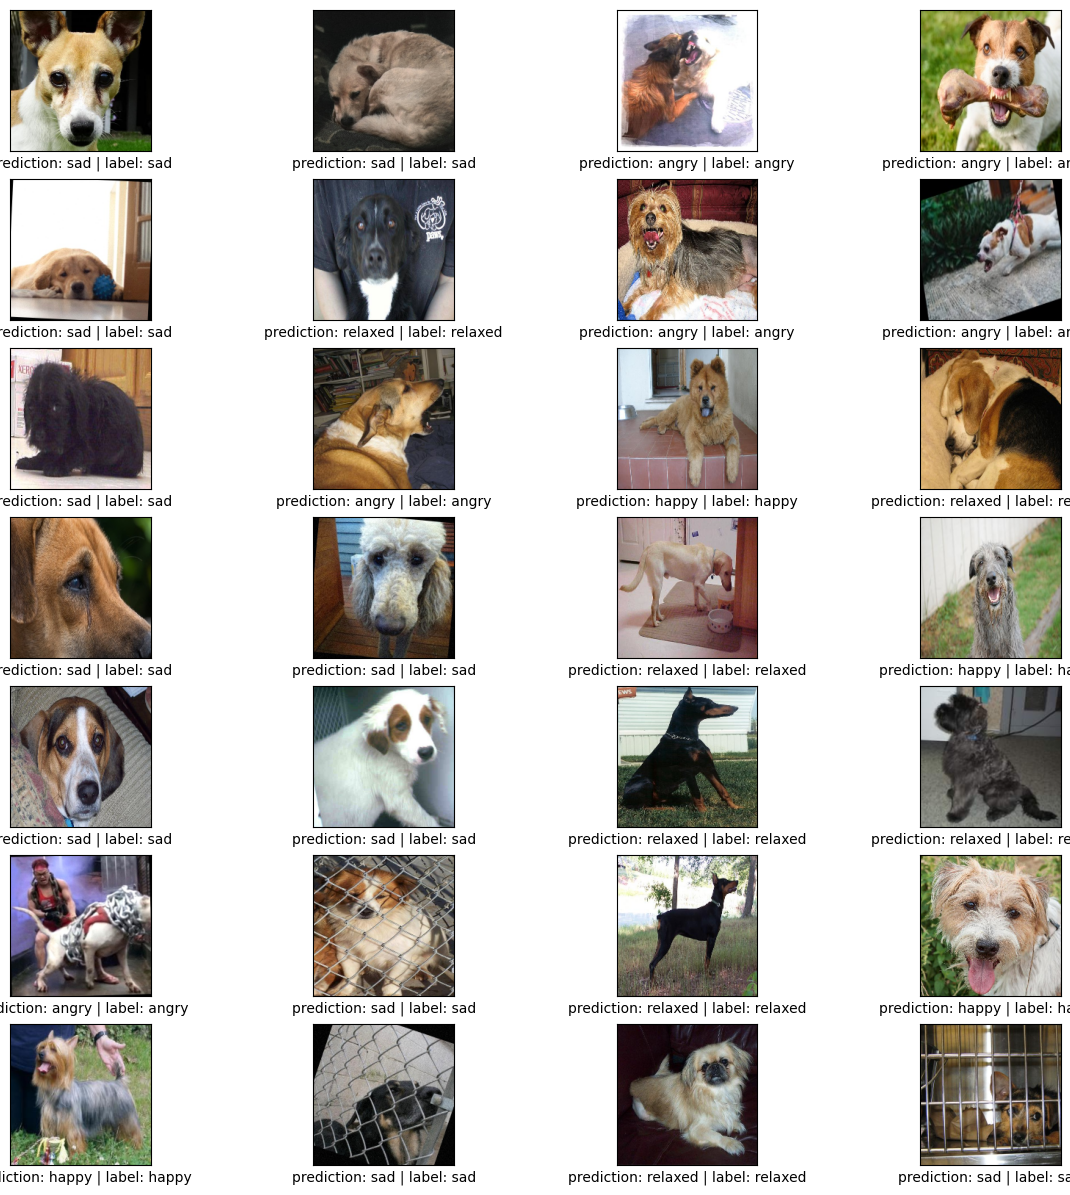

In [115]:
fig, axs = plt.subplots(7, 4, figsize=(15, 15))

i = 0
for x in range(7):
    for y in range(4):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


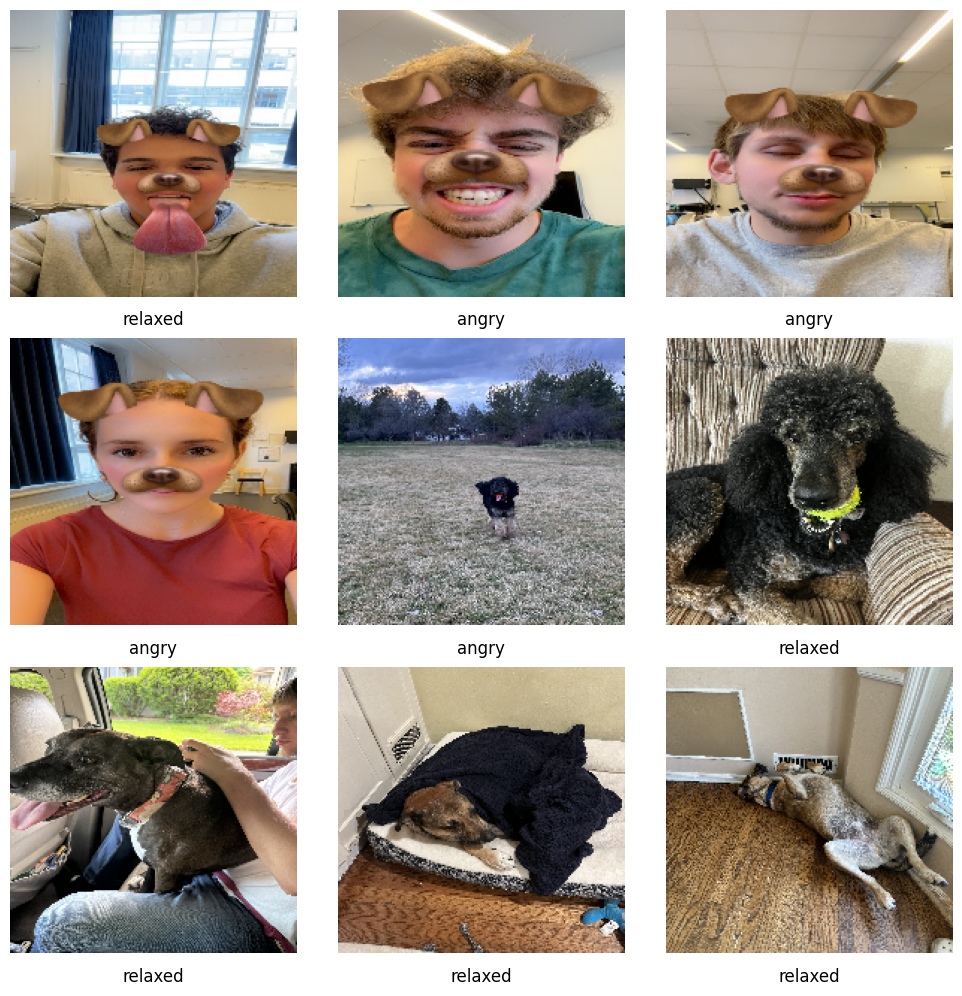

In [116]:
import matplotlib.image as mpimg
image_paths = ['dog1.jpg', 'dog2.jpg', 'dog3.jpg', 'dog4.jpg', 'micahdog.jpg', 'micahdog3.jpg', 'zachdog.jpg', 'travisdog.jpg', 'travisdog2.jpg']
subtext = ["" for x in range(9)]
i = 0
for imag in image_paths:
    img = cv2.imread(imag, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (192, 192))  # Resize to match your model's expected sizing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Preprocess the image
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    predictions = model.predict(img)
    # Get the predicted class label
    predicted_class = np.argmax(predictions)
    subtext[i] = class_names[predicted_class]
    i=i+1;


# Number of rows and columns
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    # Load image
    imag = image_paths[i]
    #img = mpimg.imread(image_paths[i])
    img = cv2.imread(imag, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (192, 192))  # Resize to match your model's expected sizing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Display image
    ax.imshow(img)
    ax.axis('off')  # Hide the axes ticks

    # Display subtext
    #ax.set_title(subtext[i], fontsize=12)
    ax.text(0.5, -0.1, subtext[i], fontsize=12, ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()